# <font color='blue'>CSE483 Computer Vision: QR Code Reader</font>
    
</div>
<img src="https://bitly.com/blog/wp-content/uploads/2023/12/qr-code-generator-and-scanner-apps.png">



<div class="alert alert-block alert-warning">
<b>Team Members:</b> 

Nadine Hisham Hassan (20P9880)

Habiba Yasser Abdelhalim (20P3072)

Salma Nasreldin (20P7105)

Ziad Mahmoud (20P2765)

Tamer Ihab (20P5567)
</div>

<div class="alert alert-block alert-info">   
<b>Steps:</b> 

1. Study ISO/IEC 18004 standard for QR codes
2. Research relevant classical computer vision algorithms.
3. Implement image preprocessing techniques.
4. Extract QR code frame (morphological operations and Hough transform).   
5. Apply geometric transformations to straighten the QR code frame.   
6. Implement manual QR decoding without machine learning or external libraries.
7. Test, debug, and ensure robustness.
8. Document implementation process, challenges, and solutions.


## <font color='Blue'>1. Defining the problem statement</font>  

<div class="alert alert-block alert-info">

The project focuses on developing an image processing pipeline using classical computer vision techniques to reliably decode QR codes. This involves preprocessing captured images to remove distortions, noise, and artifacts, extracting QR code frames accurately, applying geometric transformations for alignment, and implementing manual decoding algorithms based on ISO/IEC 18004 standard. 
    
</div>

[Test Cases](https://drive.google.com/drive/u/0/folders/1hK0BoIbEBC1YmcQrm1cHVAk7g_0jppP9)


# <font color='orange'>Import Libraries</font> 

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dctn, idctn
from scipy.ndimage import median_filter
import os


# <font color='red'>Image Preprocessing </font> 

# <font color='orange'>Pipeline </font> 

<h3> <font color='orange'>Gray Scaling </font> </h3>

In [33]:
# output_directory = "gray_images" 
# # Function to convert image to grayscale and save it
# def convert_to_grayscale(image):
#     # Convert to grayscale
#     gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
#     # Create the output directory if it doesn't exist
#     if not os.path.exists(output_directory):
#         os.makedirs(output_directory)
    
#     # Get the filename from the image path
#     filename = os.path.basename(image_path)
    
#     # Save processed image
#     output_path = os.path.join(output_directory, filename)
#     cv2.imwrite(output_path, gray_img)
#     return gray_img
def convert_to_grayscale(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_img

<h3> <font color='orange'>Removing Noise </font> </h3>

In [45]:
#taken from https://stackoverflow.com/questions/78093334/improving-bandpass-filter-for-image-processing-in-python and improvised 
def apply_bandpass_filter(image, filter_width=11, threshold=100):
    # Compute Fourier transform of the image
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # Create a filter to remove sinusoidal noise
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    # Creating mask array with the same dimensions as the input image, filled with ones
    mask = np.ones_like(image)

    # Set the filter width
    mask[crow, ccol+filter_width] = 0
    mask[crow, ccol-filter_width] = 0

    # Apply the filter mask
    f_transform_shifted_filtered = f_transform_shifted * mask

    # Do inverse Fourier transform
    fft_ifft_shift = np.fft.ifftshift(f_transform_shifted_filtered)
    image_filtered = np.fft.ifft2(fft_ifft_shift)
    image_filtered = np.abs(image_filtered)

    # Apply thresholding
    _, thresholded_image = cv2.threshold(image_filtered, threshold, 255, cv2.THRESH_BINARY)
    
    return thresholded_image

# Another Alternative albeit not generic as such
'''
def adaptive_frequency_domain_filter(image, r, alpha):
    # Apply Discrete Cosine Transform (DCT)
    dct_image = dctn(image, norm='ortho')

    # Calculate the median of the DCT coefficients
    median_dct = median_filter(np.abs(dct_image), size=(9*r+1, 9*r+1), mode='reflect')

    # Create a mask to identify peaks in the DCT coefficients
    mask = np.abs(dct_image) > alpha * median_dct

    # Apply the median filter to the DCT coefficients based on the mask
    filtered_dct = (1 - mask) * dct_image + mask * median_filter(dct_image, size=(2*r+1, 2*r+1), mode='reflect')

    # Inverse DCT to get the filtered image
    filtered_image = idctn(filtered_dct, norm='ortho')

    # Normalize the filtered image
    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX)

    return np.uint8(filtered_image)
    
filtered_image = adaptive_frequency_domain_filter(img11, r=1, alpha=6.5)

_, binary3_image = cv2.threshold(filtered_image, 95, 255, cv2.THRESH_BINARY)

kernel = np.ones((21, 21), np.uint8)

# Apply opening to the binary image
opening_image = cv2.morphologyEx(binary3_image, cv2.MORPH_OPEN, kernel)

''' 

"\ndef adaptive_frequency_domain_filter(image, r, alpha):\n    # Apply Discrete Cosine Transform (DCT)\n    dct_image = dctn(image, norm='ortho')\n\n    # Calculate the median of the DCT coefficients\n    median_dct = median_filter(np.abs(dct_image), size=(9*r+1, 9*r+1), mode='reflect')\n\n    # Create a mask to identify peaks in the DCT coefficients\n    mask = np.abs(dct_image) > alpha * median_dct\n\n    # Apply the median filter to the DCT coefficients based on the mask\n    filtered_dct = (1 - mask) * dct_image + mask * median_filter(dct_image, size=(2*r+1, 2*r+1), mode='reflect')\n\n    # Inverse DCT to get the filtered image\n    filtered_image = idctn(filtered_dct, norm='ortho')\n\n    # Normalize the filtered image\n    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX)\n\n    return np.uint8(filtered_image)\n    \nfiltered_image = adaptive_frequency_domain_filter(img11, r=1, alpha=6.5)\n\n_, binary3_image = cv2.threshold(filtered_image, 95, 255, cv2

<h3> <font color='orange'>Checking Inversion</font> </h3>

In [35]:
# Function to check and correct image inversion
def check_and_correct_inversion(image):
    # Calculate the mean pixel intensity
    mean_intensity = np.mean(image)
    
    # Check if the image is likely inverted based on mean intensity
    if 3 < mean_intensity < 127:  # Adjust threshold as needed
        print("Image is likely inverted. Inverting...")
        image = cv2.bitwise_not(image)
    
    return image


<h3> <font color='orange'>Deskewing Function </font> </h3>

In [36]:
# Function to deskew an image
def deskew_image(image):
    gray = image
    gray = 255 - gray
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Compute rotated bounding box
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    print("Skew angle: ", angle)

    # Check if the angle is close to zero (not skewed much)
    if abs(angle) == 90:
        print("Image is not skewed, no rotation needed.")
        rotated = image  # Keep the original image
    elif angle == 0:
        #angle is 0:
        #rotate it by 90 degrees
        angle = 180
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    else:
        # Rotate image to deskew
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated

<h3> <font color='orange'>Preprocessing Pipeline</font> </h3>

In [47]:
# Directory containing QR code images
directory = "Images"
output_directory = "processed_images"  # Directory to store processed images
test_cases = ["01-Getting-started.png", "02-Matsawar-3edel-ya3am.png","03-Leffy-bina-ya-donya.png", "04-Black-mirror.png",
              "10-Gone-With-The-Wind.png", "07-THE-MIGHTY-FINGER.png","13-2el-noor-2ata3.png","15.png","14-BANANAAA!!!.png"]

# Function to load and preprocess images
def preprocess_images():
    fig, axes = plt.subplots(1, len(test_cases), figsize=(20, 5))
    for i, filename in enumerate(test_cases):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            # Load image
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            
            # # Convert to grayscale
            gray_img = convert_to_grayscale(img)
            #plt.imshow(gray_img)
            # Check and correct image inversion
            corrected_img = check_and_correct_inversion(gray_img)
            
            # Deskew image
            deskewed_img = deskew_image(corrected_img)
            
            # Apply bandpass filter
            filtered_img = apply_bandpass_filter(deskewed_img)
           
            # Histogram equalization
            eq_img = cv2.equalizeHist(filtered_img)
            
            # Apply Median filter
           # filtered_img = cv2.medianBlur(eq_img, 9)  # Adjust the kernel size as needed
            
            # Apply Binary Thresholding using Otsu's method
            _, thresh_img = cv2.threshold(eq_img, 0, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)
            
            # Plot processed image
            axes[i].imshow(thresh_img, cmap='gray')
            axes[i].set_title(f"Processed Image {i+1}")
            axes[i].axis('off')

            # Save processed image
            output_path = os.path.join(output_directory, filename)
            cv2.imwrite(output_path, thresh_img)

    plt.tight_layout()
    plt.show()


# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Call the preprocessing function
#preprocess_images()

# <font color='orange'>Test Case 2: Matsawar 3edel Ya3am </font> 

Skew angle:  -8.252528190612793


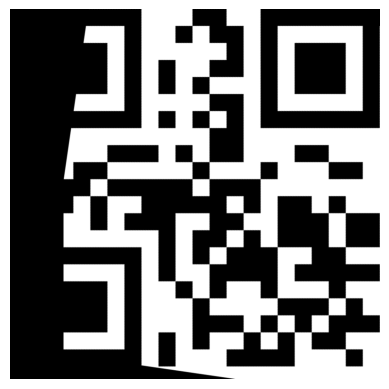

In [101]:

img2 = cv2.imread('Images/02-Matsawar-3edel-ya3am.png')
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(255-gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]

if angle < -45:
    angle = -(90 + angle)
else:
    angle = -angle
print("Skew angle: ", angle)


(h, w) = img2.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
rotated_image = cv2.warpAffine(img2, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC)

resized_image = cv2.resize(rotated_image, (968, 968), interpolation=cv2.INTER_LINEAR)


shift = 140
M = np.float32([[1, 0, shift], [0, 1, 0]])
shifted_image = cv2.warpAffine(resized_image, M, (resized_image.shape[1], resized_image.shape[0]))
shifted_gray=cv2.cvtColor(shifted_image, cv2.COLOR_BGR2GRAY)

plt.imshow(shifted_gray, cmap='gray')
plt.axis('off')
plt.show()


# <font color='orange'>Test Case 3: Leffy bina ya donya </font> 


# <font color='orange'>Test Case 4: Black Mirror </font> 


# <font color='orange'>Test Case 5: Caesar Cipher </font> 

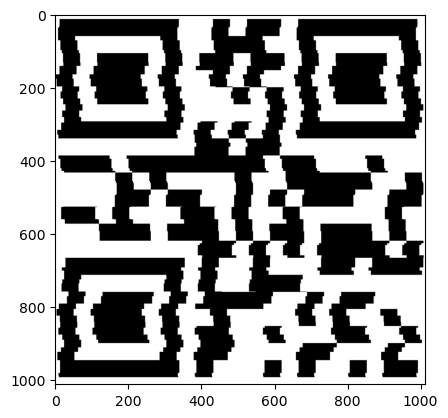

In [6]:
img5 = cv2.imread('Images/05-Caesar-cipher.png',  cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.cvtColor(img5, cv2.IMREAD_GRAYSCALE))

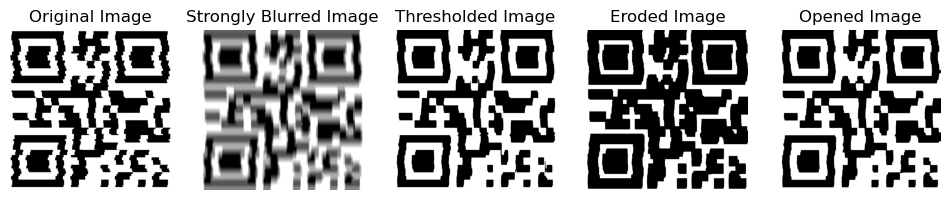

In [7]:



blurred_image5 = cv2.blur(img5, (2,70))

# Apply thresholding (binary threshold) with a higher threshold value
_, thresholded_image = cv2.threshold(blurred_image5, 128, 255, cv2.THRESH_BINARY)


kernel = np.ones((20, 20), np.uint8)



eroded_image = cv2.erode(thresholded_image, kernel, iterations=1)
dilated_image = cv2.dilate(eroded_image, kernel, iterations=1)

# Display the original, blurred, thresholded, and opened images
plt.figure(figsize=(12, 6))

plt.subplot(1, 5, 1)
plt.imshow(img5, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(blurred_image5, cmap='gray')
plt.title("Strongly Blurred Image")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(thresholded_image, cmap='gray')
plt.title("Thresholded Image")
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(eroded_image, cmap='gray')
plt.title("Eroded Image")
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(dilated_image, cmap='gray')
plt.title("Opened Image")
plt.axis('off')

plt.show()

# <font color='orange'>Test Case 6: Railfence Cipher </font> 


# <font color='orange'>Test Case 7: The Mighty Finger</font> 

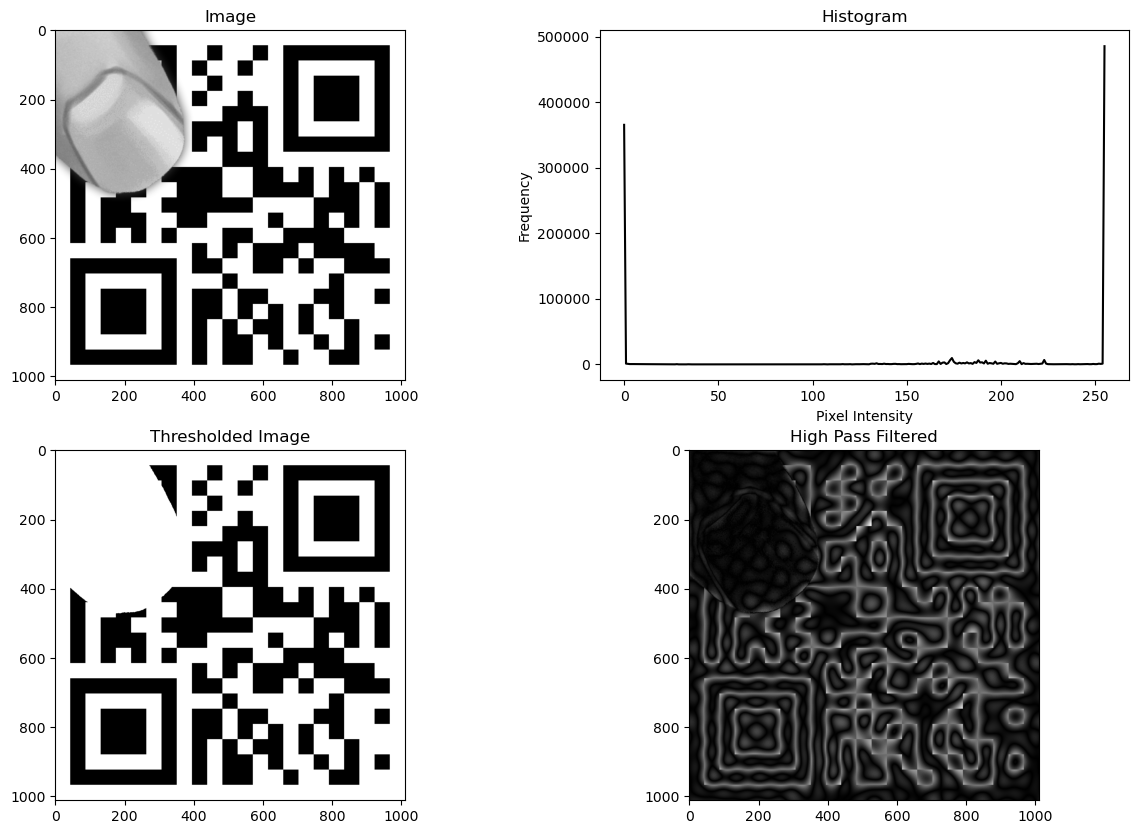

In [10]:
# Load the image
img7 = cv2.imread('Images/07-THE-MIGHTY-FINGER.png', cv2.IMREAD_GRAYSCALE)

# Calculate the histogram
hist = cv2.calcHist([img7], [0], None, [256], [0,256])

_, thresh_img = cv2.threshold(img7, 90, 255, cv2.THRESH_BINARY)

# Calculate the Fourier transform
f_transform = np.fft.fft2(img7)
f_transform_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = 20*np.log(np.abs(f_transform_shifted)+500)

# Apply high-pass filter
rows, cols = img7.shape
crow, ccol = rows//2, cols//2
mask = np.ones((rows, cols), np.uint8)
r = 15  # Radius of the circular mask
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
mask[mask_area] = 0
f_transform_shifted_filtered = f_transform_shifted * mask

# Calculate the inverse Fourier transform
f_transform_filtered = np.fft.ifftshift(f_transform_shifted_filtered)
image_filtered = np.fft.ifft2(f_transform_filtered)
image_filtered = np.abs(image_filtered)

# Display the image, its histogram, and its Fourier transform
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(img7, cmap='gray')
plt.title('Image')

plt.subplot(2, 2, 2)
plt.plot(hist, color='black')
plt.title('Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.imshow(thresh_img, cmap='gray')
plt.title('Thresholded Image')

plt.show()

# <font color='orange'>Test Case 8: Compresso Espresso </font> 


# <font color='orange'>Test Case 9: My phone fell while taking this one ... or did it </font> 

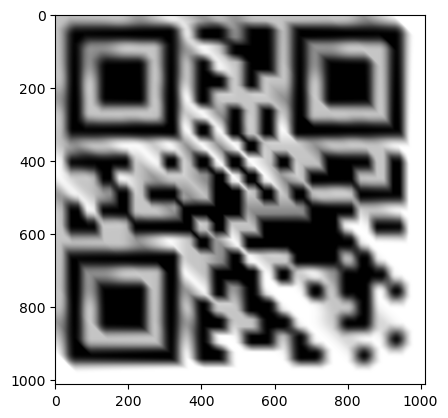

In [14]:
img9 = cv2.imread('Images/09-My-phone-fell-while-taking-this-one-...-or-did-it.png', cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(img9, cv2.COLOR_BGR2RGB))

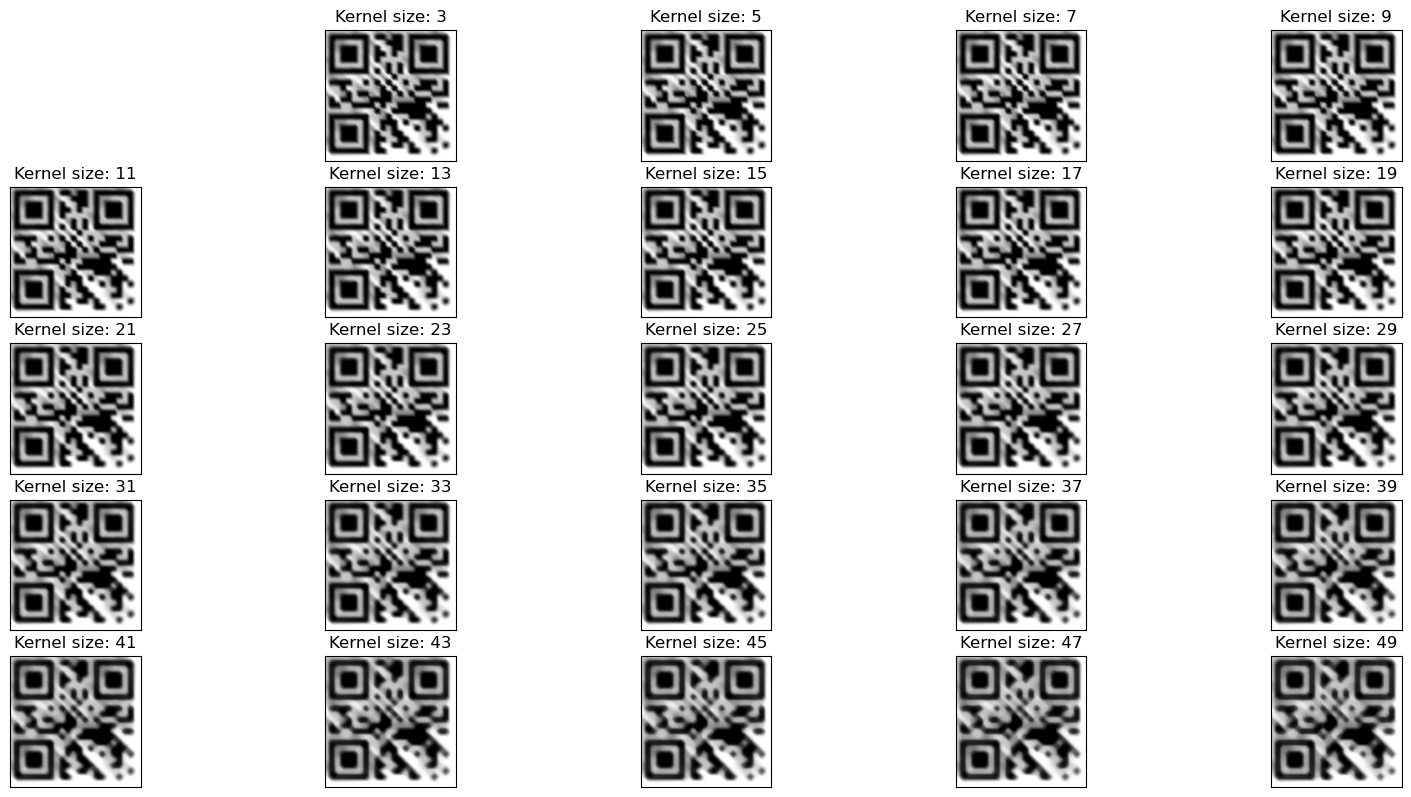

In [15]:
fig = plt.figure(figsize=(20, 20))
for i in range(3, 50, 1):
    if i % 2 == 0 or i == 1:
        continue

    blurred_image = cv2.medianBlur(img9, i)

    fig.add_subplot(10, 10, i)

    plt.title(f"Kernel size: {i}")

    # Remove ticks
    plt.xticks([])
    plt.yticks([])

    plt.imshow(blurred_image, cmap="gray")

plt.show()
     

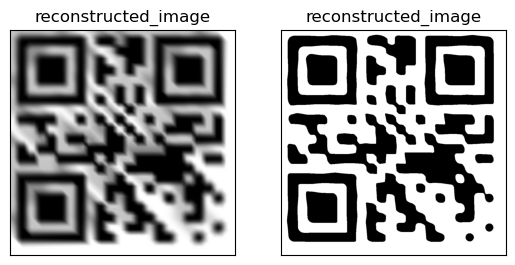

In [16]:


# Create a kernel for deconvolution (e.g., Gaussian kernel)
kernel_size = 7
kernel = cv2.getGaussianKernel(kernel_size, 0)
kernel = np.outer(kernel, kernel.transpose())

# Perform deconvolution
reconstructed_image = cv2.filter2D(img9, -9, kernel)
_, binary2_image = cv2.threshold(reconstructed_image, 95, 255, cv2.THRESH_BINARY)
flipped_image = cv2.flip(binary2_image, 1)
plt.subplot(121),plt.imshow(reconstructed_image, cmap = 'gray')
plt.title('reconstructed_image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(flipped_image[:,::-1], cmap = 'gray')
plt.title('reconstructed_image'), plt.xticks([]), plt.yticks([])
plt.show()



# <font color='orange'>Test Case 10: Gone with the Wind</font> 


# <font color='orange'>Test Case 11: weewooweewooweewoo </font> 

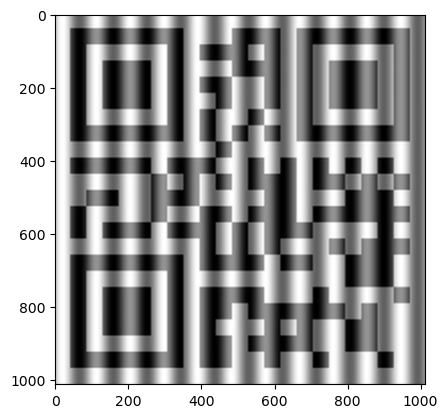

In [17]:
img11 = cv2.imread('Images/11-weewooweewooweewoo.png',  cv2.IMREAD_GRAYSCALE)
plt.imshow(img11, cmap="gray")

In [26]:
def adaptive_frequency_domain_filter(image, r, alpha):
    # Apply Discrete Cosine Transform (DCT)
    dct_image = dctn(image, norm='ortho')

    # Calculate the median of the DCT coefficients
    median_dct = median_filter(np.abs(dct_image), size=(9*r+1, 9*r+1), mode='reflect')

    # Create a mask to identify peaks in the DCT coefficients
    mask = np.abs(dct_image) > alpha * median_dct

    # Apply the median filter to the DCT coefficients based on the mask
    filtered_dct = (1 - mask) * dct_image + mask * median_filter(dct_image, size=(2*r+1, 2*r+1), mode='reflect')

    # Inverse DCT to get the filtered image
    filtered_image11 = idctn(filtered_dct, norm='ortho')

    # Normalize the filtered image
    filtered_image11 = cv2.normalize(filtered_image11, None, 0, 255, cv2.NORM_MINMAX)

    return np.uint8(filtered_image11)

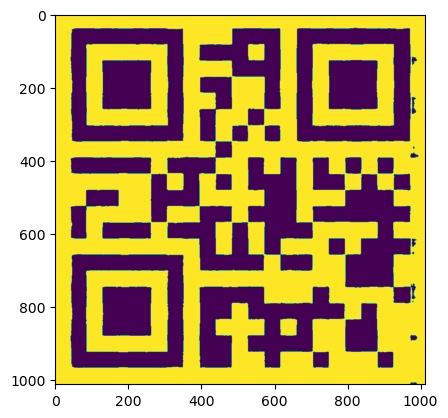

In [54]:

filtered_image11 = adaptive_frequency_domain_filter(img11, r=1, alpha=6.5)

# # Display and save the filtered image
# cv2.imshow('Filtered Image', filtered_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.imwrite('filtered_image.jpg', filtered_image)

_, binary_image11 = cv2.threshold(filtered_image11, 100, 255, cv2.THRESH_BINARY)
plt.imshow(binary_image11)

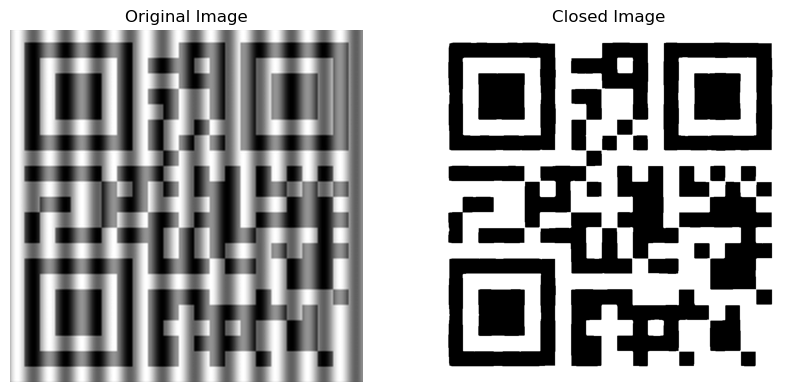

In [56]:
kernel = np.ones((21, 21), np.uint8)

# Apply opening to the binary image
#opening_image11 = cv2.morphologyEx(binary_image11, cv2.MORPH_OPEN, kernel)

closed_image11 = cv2.morphologyEx(binary_image11, cv2.MORPH_CLOSE, kernel)



# Set up the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figsize as needed

# Display the original image
axs[0].imshow(img11, cmap='gray')  # Use cmap='gray' for grayscale images
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide the axes

# Display the opened image
#axs[1].imshow(opening_image11, cmap='gray')  # Use cmap='gray' for grayscale images
#axs[1].set_title('Opened Image')
#axs[1].axis('off')  # Hide the axes

# Display the closed image
axs[1].imshow(closed_image11, cmap='gray')  # Use cmap='gray' for grayscale images
axs[1].set_title('Closed Image')
axs[1].axis('off')  # Hide the axes



# Show the plot
plt.show()

# <font color='orange'>Test Case 12: mal7-w-felfel</font> 


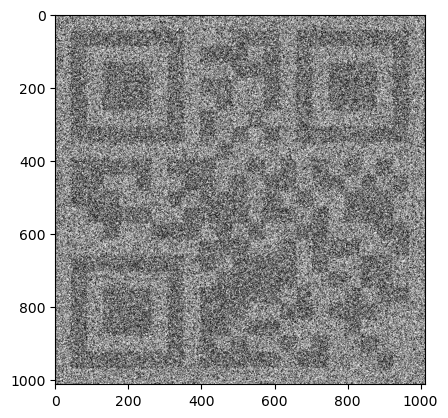

In [21]:
img12 = cv2.imread('Images/12-mal7-w-felfel.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.cvtColor(img12, cv2.IMREAD_GRAYSCALE))

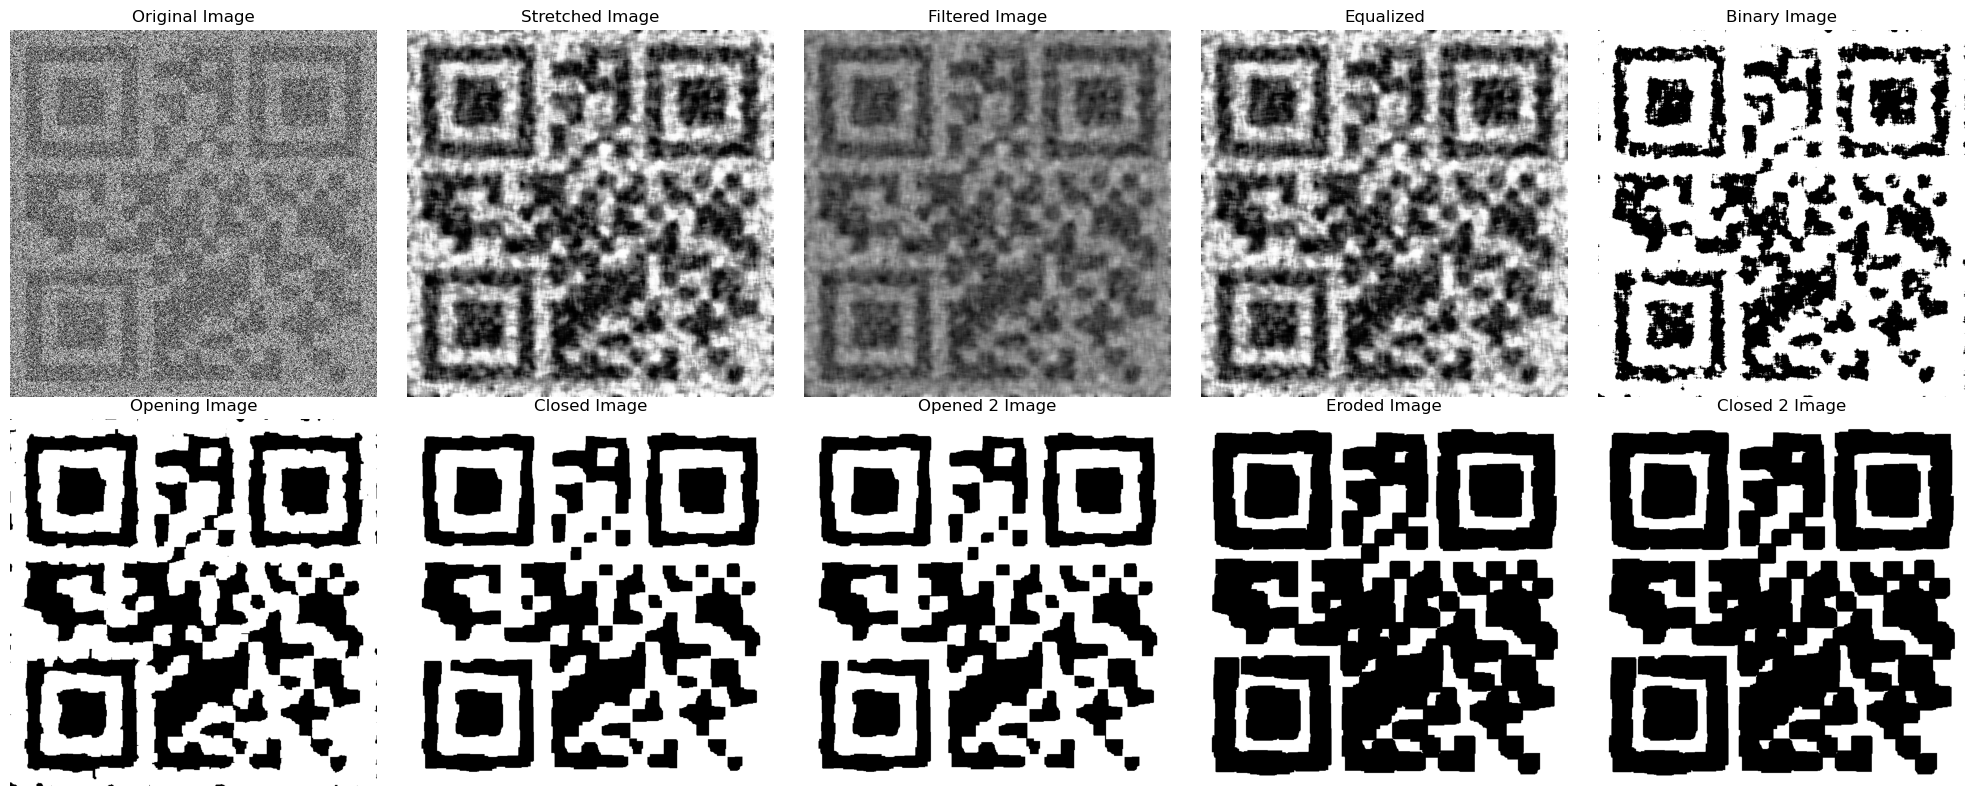

In [77]:
# Apply median filter
filtered_image12 = cv2.medianBlur(img12, 21)  # Adjust the kernel size as needed

# Apply histogram equalization to enhance the image
equalized = cv2.equalizeHist(filtered_image)

# Calculate the minimum and maximum pixel values in the image
min_val, max_val, _, _ = cv2.minMaxLoc(equalized)

# Perform contrast stretching
stretched_image = np.uint8((equalized - min_val) / (max_val - min_val) * 255)


_, binary_image12 = cv2.threshold(equalized, 85, 255, cv2.THRESH_BINARY)

kernel = np.ones((21,21), np.uint8)

# Apply opening to the binary image
opening_image12 = cv2.morphologyEx(binary_image12, cv2.MORPH_OPEN, kernel)

closed_image12 = cv2.morphologyEx(opening_image12, cv2.MORPH_CLOSE, kernel)


eroded_image12 = cv2.erode(closed_image12, kernel, iterations=1)


closed2_image12 = cv2.morphologyEx(eroded_image12, cv2.MORPH_CLOSE, kernel)


dilated_image12 = cv2.dilate(closed2_image12, kernel, iterations=1)
#opening2_image12 = cv2.morphologyEx(closed_image12, cv2.MORPH_OPEN, kernel)




fig, axs = plt.subplots(3, 5, figsize=(20, 8))  # Adjust the figure size as necessary for better visibility

# First row
axs[0, 0].imshow(img12, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(stretched_image, cmap='gray')
axs[0, 1].set_title('Stretched Image')
axs[0, 1].axis('off')

axs[0, 2].imshow(filtered_image12, cmap='gray')
axs[0, 2].set_title('Filtered Image')
axs[0, 2].axis('off')

axs[0, 3].imshow(equalized, cmap='gray')
axs[0, 3].set_title('Equalized')
axs[0, 3].axis('off')

axs[0, 4].imshow(binary_image12, cmap='gray')
axs[0, 4].set_title('Binary Image')
axs[0, 4].axis('off')

# Second row
axs[1, 0].imshow(opening_image12, cmap='gray')
axs[1, 0].set_title('Opening Image')
axs[1, 0].axis('off')

axs[1, 1].imshow(closed_image12, cmap='gray')
axs[1, 1].set_title('Closed Image')
axs[1, 1].axis('off')

axs[1, 2].imshow(opening2_image12, cmap='gray')
axs[1, 2].set_title('Opened 2 Image')
axs[1, 2].axis('off')

axs[1, 3].imshow(eroded_image12, cmap='gray')
axs[1, 3].set_title('Eroded Image')
axs[1, 3].axis('off')

axs[1, 4].imshow(closed2_image12, cmap='gray')
axs[1, 4].set_title('Closed 2 Image')
axs[1, 4].axis('off')

# Third Riw

plt.tight_layout()
plt.show()




# <font color='orange'>Test Case 13: 2el Noor Ata3 </font> 

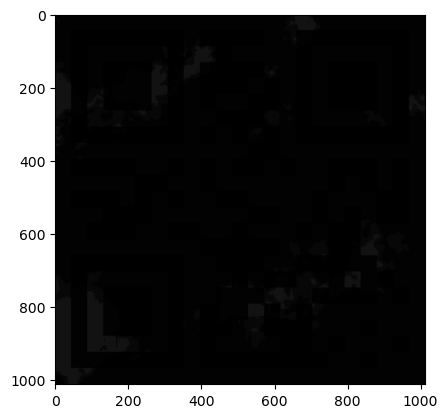

In [23]:
img13 = cv2.imread("Images/13-2el-noor-2ata3.png")
plt.imshow(img13)

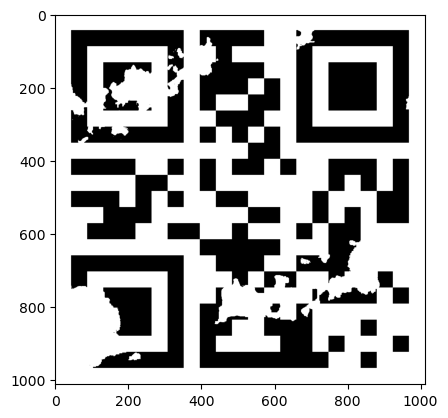

In [24]:
# Convert to grayscale
gray_img13 = cv2.cvtColor(img13, cv2.COLOR_BGR2GRAY)
# Histogram equalization
eq_img = cv2.equalizeHist(gray_img13)
# Apply Binary Thresholding using Otsu's method
_, thresh_img13 = cv2.threshold(eq_img, 0, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)
plt.imshow(thresh_img13,cmap='gray')

# <font color='orange'>Test Case 14: BANANA!!!! </font> 


# <font color='orange'>Test Case 15: Beast Mode Wikipedia </font> 

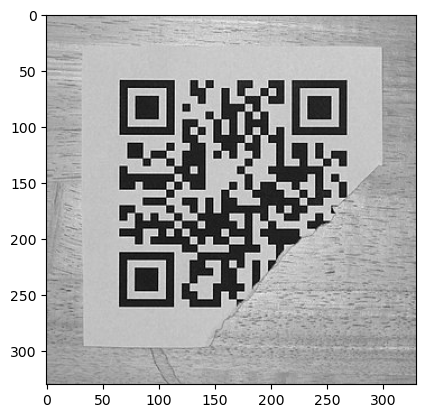

In [25]:
img15 = cv2.imread('Images/15-beast-mode-computer-vision-(this-one-is-from-wikipedia).jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.cvtColor(img15, cv2.IMREAD_GRAYSCALE))

# <font color='orange'>Test Case 16: Can you do it?? </font> 


# <font color='Red'>Decoding</font>  


# <font color='blue'>Outer Frame Detection</font>  


In [103]:
start_row = -1
start_col = -1
end_row = -1
end_col = -1

img=closed_image12

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break

print(start_row, end_row, start_col, end_col)

38 973 40 974


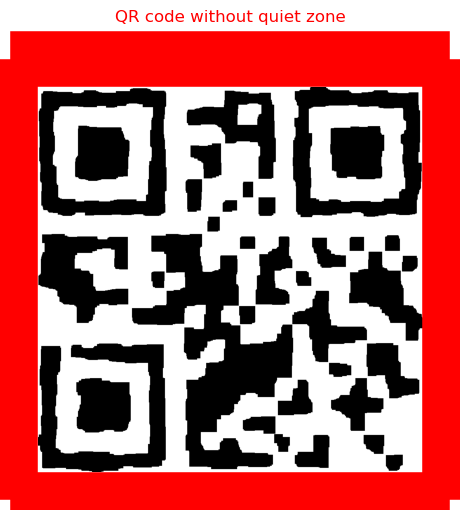

In [104]:
qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
fig.get_axes()[0].spines[:].set_color('red');
fig.get_axes()[0].spines[:].set_linewidth(40);
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title('QR code without quiet zone', y = 1.15, color='red');
plt.imshow(qr_no_quiet_zone, cmap='gray');

In [97]:
size = 0
for pixel in qr_no_quiet_zone[0]:
    if (pixel != 0): break
    size += 1

print(size)

0


# <font color='red'>Pipeline</font> 